# Practical 2

**Group composition**: 
- Lucie-Marie &bull; [lucie-marie.boschiancampaner@ensiie.fr](mailto:lucie-marie.boschiancampaner@ensiie.fr)
- Khalil BATTIKH &bull; [khalil.battikh@ensiie.fr](mailto:khalil.battikh@ensiie.fr)
- Lucas RODRIGUEZ &bull; [lucas.rodriguez@ensiie.fr](mailto:lucas.rodriguez@ensiie.fr)

**Group ID**: 12

**Author**: *Lucas RODRIGUEZ*

## First steps

In [130]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import missingno as msno
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Setting up a fixed random seed for experiment purposes
np.random.seed(1)

The chosen dataset is the following : **Air Quality**.

- Link of the dataset description: https://archive.ics.uci.edu/ml/datasets/Air+Quality
- Direct link to the dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/00360/


**Selected strategy** : The given dataset offers a lot of features and observations. However, a lot of irregularities have been detected by us. We have to perform heavy transformations on the dataset using pre-processing operations.

To do so, we can first think about using Numpy, for matrix-based manipulations. However, we have decided to use Pandas to deal with tabular data more easily then convert the output version into a Numpy matrix as input for our NN model.

In [192]:
# Importing the given dataset
file_name = "data/AirQualityUCI.csv"
df = pd.read_csv(filepath_or_buffer=file_name,
                sep=";",
                #index_col="Date",
                na_values=np.nan,
                decimal=",") # Floating point separator for implicit casting

# Making a deep copy for safety reason
df_initial = df.copy(deep=True)

In [193]:
# Some informations about the different columns composing the csv file
df.info()

# General shape of the DataFrame
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB


(9471, 17)

The dataset initially contains 9471 rows and 16 columns.

### Dataset description

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value. 


---

0. Date (format: DD/MM/YYYY)
1. Time (format: HH.MM.SS)
2. True hourly averaged concentration CO in $\text{mg}/\text{m}^3$ (reference analyzer) 
3. PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted) 
4. True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) 
5. True hourly averaged Benzene concentration in microg/m^3 (reference analyzer) 
6. PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted) 
7. True hourly averaged NOx concentration in ppb (reference analyzer) 
8. PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) 
9. True hourly averaged NO2 concentration in microg/m^3 (reference analyzer) 
10. PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted) 
11. PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted) 
12. Temperature (in °C)
13. Relative Humidity (%) 
14. AH: Absolute Humidity


### Dataset references & License



Saverio De Vito (saverio.devito@enea.it), ENEA - National Agency for New Technologies, Energy and Sustainable Economic Development

In [194]:
# A quick overview of the dataset structure
df.head(8)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN
5,10/03/2004,23.00.00,1.2,1197.0,38.0,4.7,750.0,89.0,1337.0,96.0,1393.0,949.0,11.2,59.2,0.7848,NaN,NaN
6,11/03/2004,00.00.00,1.2,1185.0,31.0,3.6,690.0,62.0,1462.0,77.0,1333.0,733.0,11.3,56.8,0.7603,NaN,NaN
7,11/03/2004,01.00.00,1.0,1136.0,31.0,3.3,672.0,62.0,1453.0,76.0,1333.0,730.0,10.7,60.0,0.7702,NaN,NaN


## Data pre-processing

### Drop duplicates

We can handle duplicate rows by using the following instruction


In [195]:
df.drop_duplicates(inplace=True) # we keep the "keep" argument to its default value : "first"
df.shape

(9358, 17)

We have successfully eliminated $9471 - 9347 = \fbox{124}$ rows (especially, most of them were rows filled of NaN values (see next section). 

In [196]:
# We first determine for each column, the number of different values in this column by using the following Pandas method
df.nunique()

Date              391
Time               24
CO(GT)             97
PT08.S1(CO)      1042
NMHC(GT)          430
C6H6(GT)          408
PT08.S2(NMHC)    1246
NOx(GT)           926
PT08.S3(NOx)     1222
NO2(GT)           284
PT08.S4(NO2)     1604
PT08.S5(O3)      1744
T                 437
RH                754
AH               6684
Unnamed: 15         0
Unnamed: 16         0
dtype: int64

### Drop useless columns

We can easily see, thanks to the previous cell, that the last two columns are completely empty

$\Longrightarrow$ We immediately remove them.

In [197]:
try: # try-except block in order to catch the thrown exception in case of re-execution 
    df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)
    df.shape
except KeyError:
    print("Columns already removed.")
df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9353,04/04/2005,11.00.00,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,04/04/2005,12.00.00,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,04/04/2005,13.00.00,2.1,1003.0,-200.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139
9356,04/04/2005,14.00.00,2.2,1071.0,-200.0,11.9,1047.0,265.0,654.0,168.0,1129.0,816.0,28.5,13.1,0.5028


### Customizing the inner structure of the dataset

We observe that `Date` and `Time` are `object`-typed. Since we want to perform a regression model on our data, we want to explain the target variable with the widest subset of possible features.



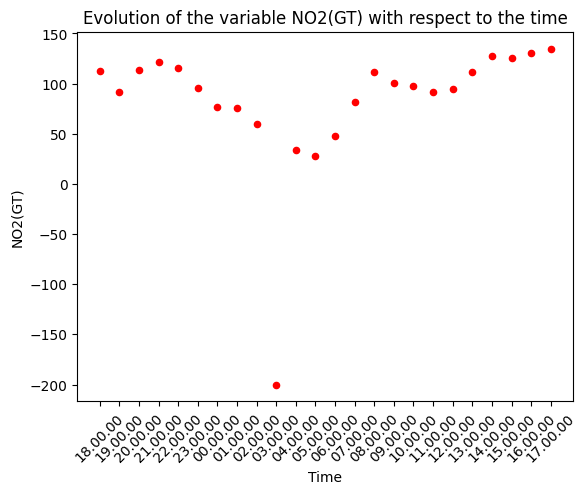

In [198]:
_ = df[0:24].plot.scatter("Time", "NO2(GT)", 
                      rot=45, 
                      color="red"
                     )
_ = plt.title("Evolution of the variable NO2(GT) with respect to the time")

We can see that, on the scale of only one day, the evolution of concentration of some substances is clearly highlighted here.

We have:
- `Date`: DD/MM/YYYY
- `Time`: HH.MM.SS (but the frequency of observation is an hourly-basis.



We also observe that the date range goes from 10/03/2004 to 03/04/2005; we can remove the year detail and only encode the month as follows:
- March 2004 $\longrightarrow 0$
- April 2004 $\longrightarrow 1$ 
- ...

As shown in the below figures, we see that there is no clear reason in keeping the days into the dataset; we remove them.


To conclude, we have decided to keep the months (as an encoded field) and the hours (the minutes and seconds dedicated fields are empty because of the hourly refresh time frequency.

In [201]:
# Creating the month column
get_month = lambda x:x.split("/")[1][1] if x.split("/")[1][0] == '0' else x.split("/")[1]
df["Month"] = df["Date"].apply(get_month)
df["Month"] = pd.to_numeric(df["Month"])

In [202]:
# Creating the hour column
get_hour = lambda x:x.split(".")[0][0] if x.split(".")[0][1] == '0' else x.split(".")[0]
df["Hour"] = df["Time"].apply(get_hour)
df["Hour"] = pd.to_numeric(df["Hour"])

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Month          9357 non-null   int64  
 16  Hour           9357 non-null   int64  
dtypes: float64(13), int64(2), object(2)
memory usage: 1.

In [204]:
# Dropping the column Date and Time
try: # try-except block in order to catch the thrown exception in case of re-execution 
    df.drop(['Date', 'Time'], axis=1, inplace=True)
    df.shape
except KeyError:
    print("Columns already removed.")
df

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Month,Hour
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,3,18
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,3,19
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,3,2
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,3,21
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,3,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,4,1
9353,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,4,11
9354,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,4,12
9355,2.1,1003.0,-200.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,4,13


### Thresholding the values ($-200 = \text{NaN}$)

### Handling missing values (NaN)

In order to train and validate our model, we cannot tolerate the presence of NaN values within the input dataset

$\Longrightarrow$ We remove them.

**Remark** : Most of them have been removed thanks to the `drop_duplicate` operation. However, we still have a remaining row at the end. We remove it.

In [205]:
df.dropna(how="all", inplace=True)
df.shape

(9357, 15)

To have a graphical confirmation, we can produce the two bar plots below showing the "distribution" of the missing values among our dataset. We can observe that we have eliminate all the missing values.

<AxesSubplot:>

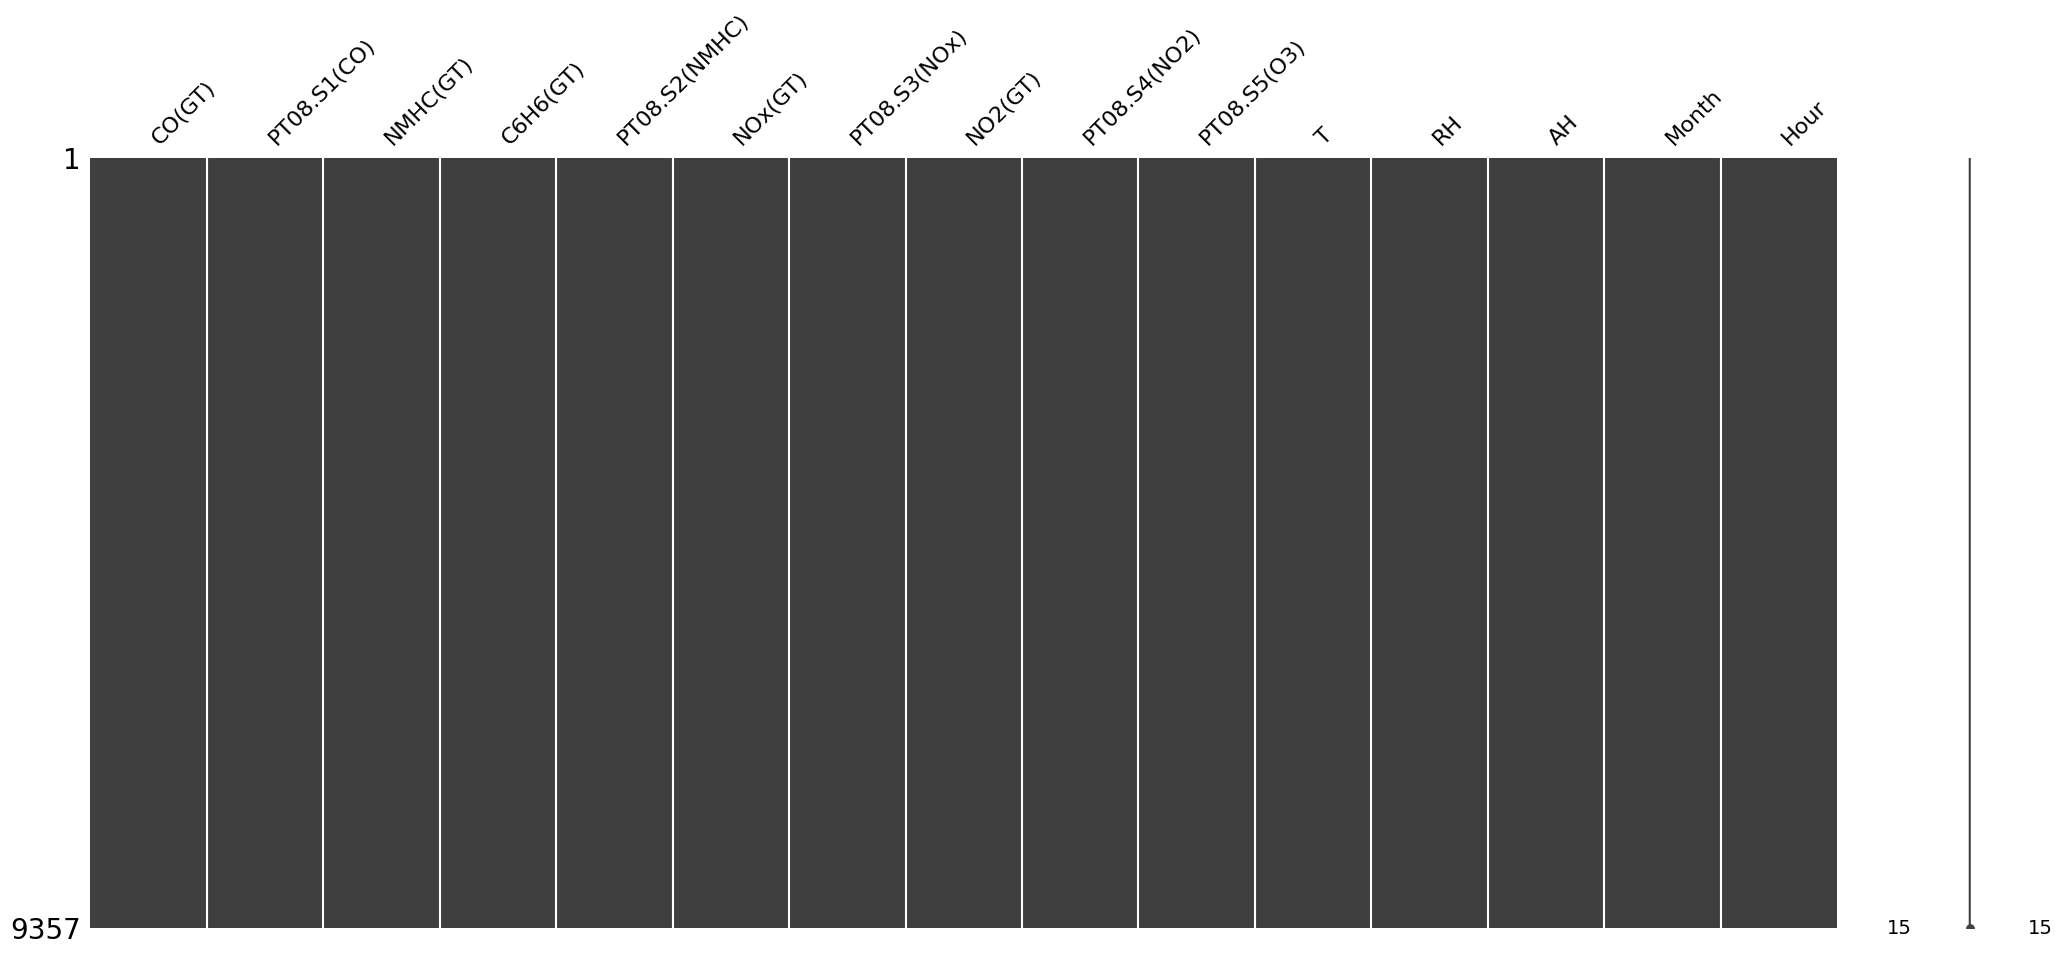

In [206]:
msno.matrix(df)

<AxesSubplot:>

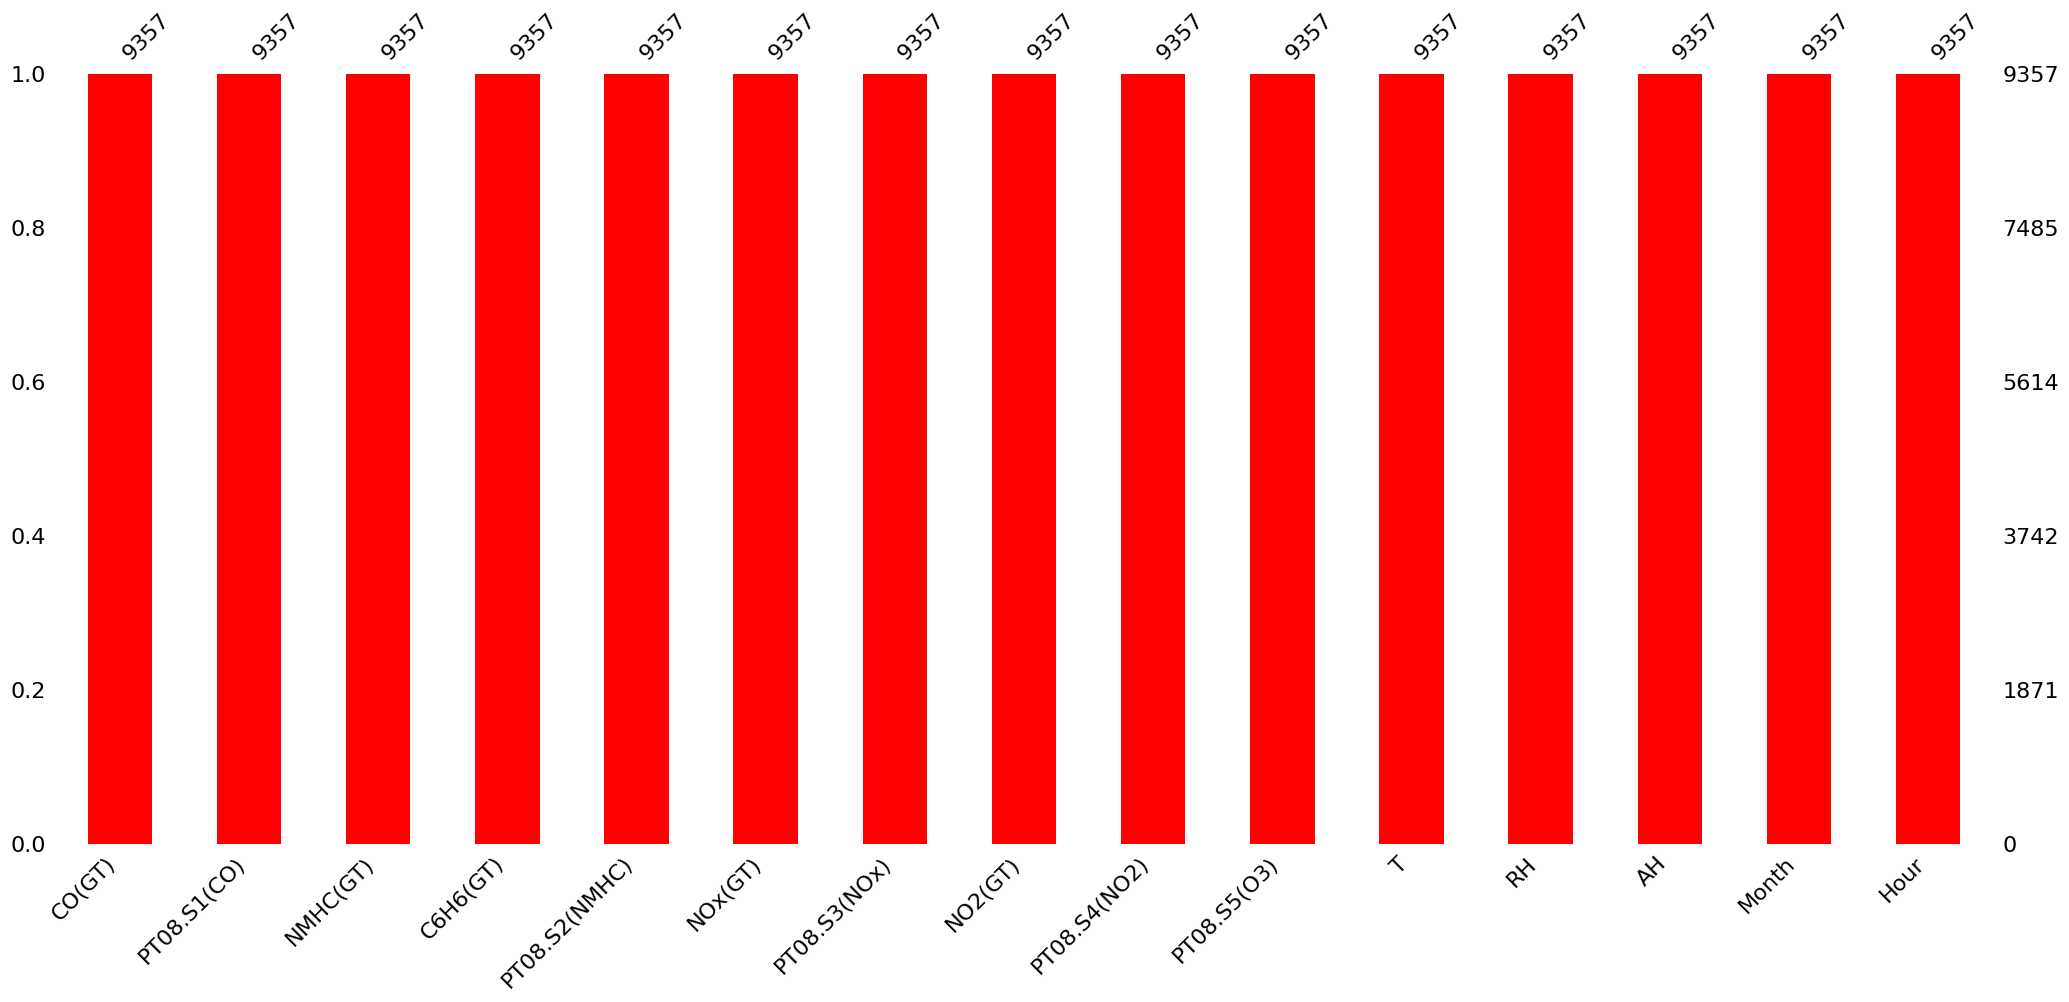

In [207]:
msno.bar(df, color="red")

## NN model